In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_06cMagda import *

In [3]:
mnist_bunch = quick_mnist_data()

## Better learner

In [4]:
#export
class Learner():
    def __init__(self, data_bunch, model, optimizer, loss_func, callback_list=[]):
        assert isinstance(data_bunch, DataBunch), 'First paramtere should be a DataBunch'
        assert isinstance(callback_list, list), 'Second paramters should be a LIST (of callbacks)'
        self.data_bunch = data_bunch
        self.model = model
        self.loss_func = loss_func
        self._get_optimizer(optimizer)
        self.callback_list = callback_list + [PlotsCallback()]
        for cb in self.callback_list:
            cb.init_learner(self)
        self.epoch = 0
        self.batch_x = None
        self.batch_y = None
        self.metrics = {}

    def _get_optimizer(self, optimizer, lr=0.5):
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

    def forward(self, bx, by):
        logits = self.model(bx)
        loss = self.loss_func(logits, by)
        return logits, loss

    def backward(self, loss):
        loss.backward()
        self.callback('before_optim_step')
        self.optimizer.step()
        self.optimizer.zero_grad()

    def fit(self, epochs):
        assert isinstance(epochs, int), 'Number of epochs should be INT'
        self.total_epochs = epochs
        self.callback('fit_begin')
        for self.epoch in range(epochs):
            try:
                self.model.train()
                self.callback('train_begin')
                for (self.batch_x, self.batch_y) in self.data_bunch.train_dl:
                    self.callback('train_batch_begin')
                    logits, loss = self.forward(self.batch_x, self.batch_y)
                    self.backward(loss)
                    self.callback('train_batch_end', loss)
                self.model.eval()
                with torch.no_grad():
                    self.callback('validation_begin')
                    for (self.batch_x, self.batch_y) in self.data_bunch.valid_dl:
                        self.callback('validation_batch_begin')
                        logits, loss = self.forward(self.batch_x, self.batch_y)
                        self.callback('validation_batch_end', logits, loss)
                self.callback('epoch_end')
            except EarlyStopping:
                print(self.epoch, 'stopping ... ')
                break
        self.callback('fit_end')

    def callback(self, cb_name, *args, **kwargs):
        for cb in self.callback_list:
            cb_method = getattr(cb, cb_name, None)
            if cb_method:
                cb_method(*args, **kwargs)

In [5]:
optimizer = optim.SGD
loss_func = F.cross_entropy
model = nn.Sequential(
    nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(),
    nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, 10)
)

In [6]:
device = torch.device('cuda')
cb_list = [ReshapeMnist(), CudaCallback(device), LossCallback(), AccuracyCallback()]
learner = Learner(mnist_bunch, model, optimizer, loss_func, cb_list)

In [7]:
learner.fit(5)

train:  2.285607099533081 validation:  1.9642009735107422
train:  0.25232309103012085 validation:  0.2292005568742752
train:  0.124610535800457 validation:  0.1302984058856964
train:  0.07463619858026505 validation:  0.09150710701942444
train:  0.07775798439979553 validation:  0.07968509197235107
Final accuracy: 0.976700


## Better weight monitoring

In [8]:
#export
class WeightsMonitoringCallback(Callback):
    def fit_begin(self):
        for layer in self.learner.model.children():
            if hasattr(layer, 'weight'):
                layer.weights_mean = []
                layer.weights_std = []
                layer.weights_mean = []
                layer.weights_std = []

    def before_optim_step(self):
        for layer in self.learner.model.children():
            try:
                weight = layer.weight.detach()
                layer.weights_mean.append(weight.mean().item())
                layer.weights_std.append(weight.std().item())
                layer.weights_mean.append(weight.grad.mean().item())
                layer.weights_std.append(weight.grad.std().item())
            except AttributeError:
                pass

In [9]:
#export
class InitCallback(Callback):
    def fit_begin(self):
        for layer in self.learner.model.children():
            try:
                init.kaiming_normal_(layer.weight)
                init.zeros_(layer.bias)
            except AttributeError:
                pass
        print('All layers initialised')

In [10]:
model = nn.Sequential(
    nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(),
    nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, 10)
)
device = torch.device('cuda')
cb_list = [
    ReshapeMnist(),
    CudaCallback(device),
    LossCallback(),
    AccuracyCallback(),
    InitCallback(),
#     HooksCallback(LsuvHook),
    WeightsMonitoringCallback()
]
learner = Learner(mnist_bunch, model, optimizer, loss_func, cb_list)

In [11]:
learner.fit(3)

initialised layer: Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
initialised layer: Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
initialised layer: Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
initialised layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
initialised layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
initialised layer: Linear(in_features=64, out_features=10, bias=True)
train:  0.6497827172279358 validation:  0.4034479856491089
train:  0.2080659419298172 validation:  0.13958822190761566
train:  0.06444238126277924 validation:  0.0940057709813118
Final accuracy: 0.970400


In [12]:
for l in model.children():
    try:
        print(l.weights_mean[0])
    except AttributeError:
        pass

0.017663946375250816
0.004145846236497164
0.002812429564073682
-0.00048122223233804107
4.763650940731168e-05
0.003855240298435092


## LSUV

In [13]:
def get_one_batch_bunch(data_bunch):
    batch_x, batch_y = data_bunch.train_data[0:data_bunch.train_bs]
    one_batch_bunch = DataBunch(batch_x, batch_y, batch_x, batch_y, data_bunch.train_bs)
    return one_batch_bunch

In [14]:
one_batch_bunch = get_one_batch_bunch(mnist_bunch)

In [15]:
#export
def get_one_batch_bunch(data_bunch):
    batch_x, batch_y = data_bunch.train_data[0:data_bunch.train_bs]
    return batch_x, batch_y

In [26]:
#export
def lsuv_init(model, batch_x):
    hooks = []

    for layer in model.children():
        try:
            init.kaiming_normal_(layer.weight)
            init.zeros_(layer.bias)
            hooks.append(layer.register_forward_hook(OutputStatsHook.forward_hook))
        except AttributeError:
                pass
    
    for i in range(10):
        model(batch_x)
        layers_done = []
        for layer in model.children():
            try:
                if abs(layer.output_stats['means'][-1]) > 1e-3:
                    layer.bias.data = layer.bias.data - layer.output_stats['means'][-1]
                    layers_done.append(False)
                else:
                    layers_done.append(True)
                if abs(layer.output_stats['stds'][-1] - 1) > 1e-3:
                    layer.weight.data = layer.weight.data / layer.output_stats['stds'][-1]
                    layers_done.append(False)
                else:
                    layers_done.append(True)
            except AttributeError:
                pass
        if all(layers_done):
            print('All layers initialised')
            break
    
    while len(hooks) > 0:
        hook = hooks.pop()
        hook.remove()


In [27]:
batch_x, _ = get_one_batch_bunch(mnist_bunch)

In [28]:
model = nn.Sequential(
    nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(),
    nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, 10)
)

In [29]:
lsuv_init(model, batch_x.view(-1, 1, 28, 28))

All layers initialised


In [32]:
layers = model.children()
for layer in layers:
    try:
        print(layer, 'mean', layer.output_stats['means'][-1], 'std', layer.output_stats['stds'][-1])
    except AttributeError:
        print(layer, 'no stats')

Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) mean -1.8635954290857626e-07 std 1.0
ReLU() no stats
Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) mean 0.00013700549607165158 std 0.9999999403953552
ReLU() no stats
Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) mean -0.0003961618640460074 std 1.0
ReLU() no stats
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) mean -0.0007452480494976044 std 1.0
ReLU() no stats
Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) mean -0.0006646662950515747 std 1.0
ReLU() no stats
AdaptiveAvgPool2d(output_size=1) no stats
Flatten() no stats
Linear(in_features=64, out_features=10, bias=True) mean 1.4901161193847656e-08 std 0.9999999403953552


In [33]:
device = torch.device('cuda')
cb_list = [ReshapeMnist(), CudaCallback(device), LossCallback(), AccuracyCallback()]
learner = Learner(mnist_bunch, model, optimizer, loss_func, cb_list)

In [34]:
learner.fit(5)

train:  0.711280345916748 validation:  0.5334076881408691
train:  0.2277151495218277 validation:  0.2403799295425415
train:  0.11383930593729019 validation:  0.14374904334545135
train:  0.06739342957735062 validation:  0.11010250449180603
train:  0.14088208973407745 validation:  0.09102334827184677
Final accuracy: 0.973500


In [35]:
layers = model.children()
layer = next(layers)
layer.output_stats['means']

[0.022671416401863098,
 -0.005423418711870909,
 -1.8635954290857626e-07,
 -1.8635954290857626e-07,
 -1.8635954290857626e-07,
 -1.8635954290857626e-07,
 -1.8635954290857626e-07,
 -1.8635954290857626e-07,
 -1.8635954290857626e-07]

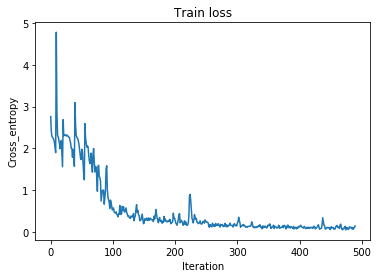

In [37]:
learner.plot_train_loss()

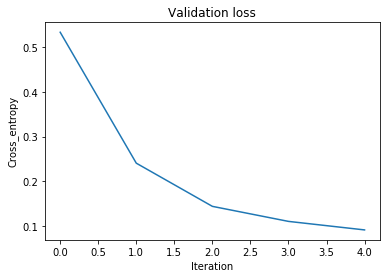

In [39]:
learner.plot_validation_loss()

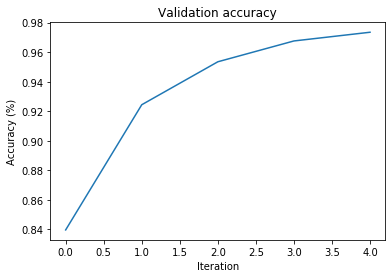

In [41]:
learner.plot_accuracy()

In [ ]:
nb_auto_export()